In [82]:
# Import the necessary libraries
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.io import loadmat
from scipy.optimize import minimize

In [83]:
# Load in the diffusion MRI data set
dwis = loadmat('data_p1/data.mat')['dwis']
dwis = np.double(dwis)
dwis = dwis.transpose((3, 0, 1, 2))
[Dc, Dx, Dy, Dz] = dwis.shape
print(dwis.shape)

(108, 145, 174, 145)


In [84]:
# And the settings for each component image
qhat = np.loadtxt("data_p1/bvecs", delimiter = " ").T
bvals = 1000 * np.sum(qhat * qhat, axis=1)
print(qhat.shape, bvals.shape)

(108, 3) (108,)


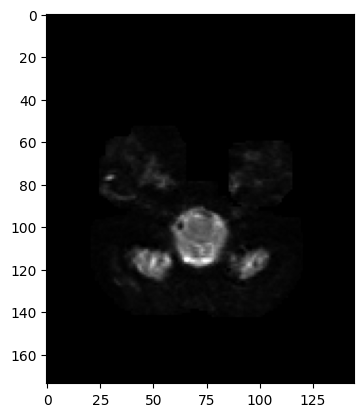

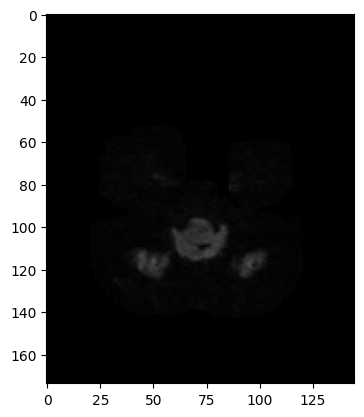

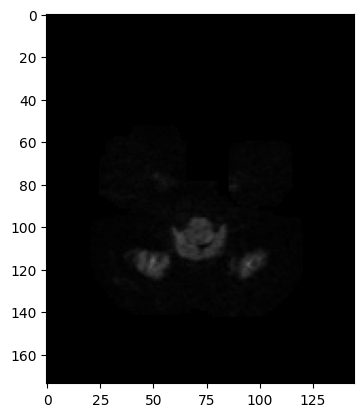

In [85]:
for i in range(0,3):
    plt.figure()
    plt.imshow(np.flipud(dwis[i,:,:,16].T),cmap='gray',vmax=10000)
    plt.show()

In [86]:
d_map = (np.log(dwis[0,:,:,71]) - np.log(dwis[1,:,:,71]))/bvals[1]

C:\Users\Gugu\AppData\Local\Temp\ipykernel_11188\1139331770.py:1: RuntimeWarning: divide by zero encountered in log
  d_map = (np.log(dwis[0,:,:,71]) - np.log(dwis[1,:,:,71]))/bvals[1]
C:\Users\Gugu\AppData\Local\Temp\ipykernel_11188\1139331770.py:1: RuntimeWarning: invalid value encountered in subtract
  d_map = (np.log(dwis[0,:,:,71]) - np.log(dwis[1,:,:,71]))/bvals[1]


In [87]:
d_map = np.zeros((Dx,Dy))
for i in range(0,Dx):
    for j in range(0,Dy):
        if dwis[0,i,j,71] > 0 and dwis[1,i,j,71] > 0:
            d_map[i,j] = (np.log(dwis[0,i,j,71]) - np.log(dwis[1,i,j,71]))/bvals[1]

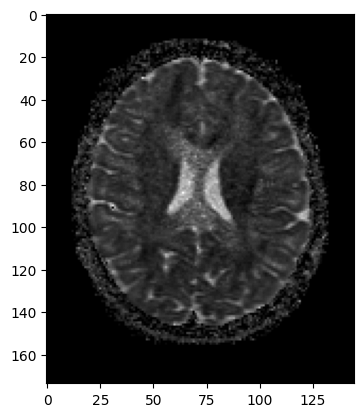

In [88]:
#Set all values that are less than 0 to zero. I.e voxels that are outside the cranium or where there is no actual water.
d_map[np.where(d_map<0)] = 0
plt.figure()
plt.imshow(np.flipud(d_map.T),cmap='gray')
plt.show()

$\Large{Q.1.1.1}$

In [89]:
X, Y = dwis.shape[1], dwis.shape[2]  # Get spatial dimensions
dt_map72 = np.zeros((7, X, Y))  # Initialize tensor map

In [90]:
Avox = dwis[:, 91, 64, 71]
#NOTE: python uses 0 indexing
log_Avox = np.log(Avox)

In [91]:
# Construct Y matrix with correctly shaped qhat
G = np.column_stack([
    np.ones(len(bvals)),
    -bvals * qhat[:, 0]**2,
    -2 * bvals * qhat[:, 0] * qhat[:, 1],
    -2 * bvals * qhat[:, 0] * qhat[:, 2],
    -bvals * qhat[:, 1]**2,
    -2 * bvals * qhat[:, 1] * qhat[:, 2],
    -bvals * qhat[:, 2]**2
])


In [92]:
Gi = np.linalg.pinv(G)  # Shape: (7, N)


In [93]:
dt_map = np.zeros((7, Dx, Dy))

for i in range(Dx):
    for j in range(Dy):
        if np.min(dwis[:, i, j, 71]) > 0:
            A = dwis[:, i, j, 71]
            x = Gi @ np.log(A)  # Now x.shape == (7,)
            dt_map[:, i, j] = x  # No shape mismatch


In [100]:
# # Solve for x using least squares
# x_hat, _, _, _ = np.linalg.lstsq(Y, log_Avox, rcond=None)

# # Print results
# print("Estimated x:", x_hat)


LinAlgError: 0-dimensional array given. Array must be two-dimensional

In [95]:
# # Extract elements from x_hat
# D = np.array([
#     [x_hat[1], x_hat[2], x_hat[3]],
#     [x_hat[2], x_hat[4], x_hat[5]],
#     [x_hat[3], x_hat[5], x_hat[6]]
# ])

# # Print the diffusion tensor
# print("Diffusion Tensor D:\n", D)


In [96]:
# Compute trace of D
# trace_D = np.trace(D)

# print("Trace of D:", trace_D)


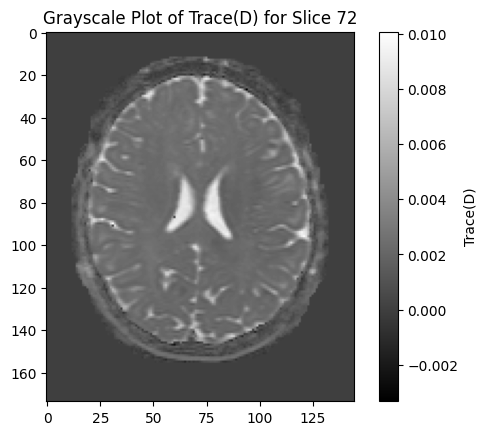

In [97]:
# Extract diagonal elements from the tensor map for slice 72
D_xx = dt_map[1, :, :]  # MATLAB indices start at 1, Python at 0
D_yy = dt_map[4, :, :]
D_zz = dt_map[6, :, :]

# Compute trace
trace_D = D_xx + D_yy + D_zz

# Flip and transpose to match MATLAB visualization
trace_D = np.flipud(trace_D.T)

# Plot grayscale image
plt.imshow(trace_D, cmap="gray")
plt.colorbar(label="Trace(D)")
plt.title("Grayscale Plot of Trace(D) for Slice 72")
plt.show()

In [98]:
# Assuming dt_map has shape (7, Dx, Dy)
Dx, Dy = dt_map.shape[1], dt_map.shape[2]

# Initialize a 3x3 tensor field
D = np.zeros((3, 3, Dx, Dy))

# Assign the symmetric components of the diffusion tensor
D[0, 0, :, :] = dt_map[1, :, :]  # D_xx
D[0, 1, :, :] = dt_map[2, :, :]  # D_xy
D[0, 2, :, :] = dt_map[3, :, :]  # D_xz

D[1, 0, :, :] = dt_map[2, :, :]  # D_yx (same as D_xy)
D[1, 1, :, :] = dt_map[4, :, :]  # D_yy
D[1, 2, :, :] = dt_map[5, :, :]  # D_yz

D[2, 0, :, :] = dt_map[3, :, :]  # D_zx (same as D_xz)
D[2, 1, :, :] = dt_map[5, :, :]  # D_zy (same as D_yz)
D[2, 2, :, :] = dt_map[6, :, :]  # D_zz

In [99]:
from numpy.linalg import eig

# Compute eigenvectors and eigenvalues of D (assume D is (3,3,Dx,Dy))
eigenvalues, eigenvectors = np.linalg.eigh(D)

# Extract primary eigenvector (largest eigenvalue)
v1 = eigenvectors[:, :, :, -1]  # Shape: (3, Dx, Dy)

LinAlgError: Last 2 dimensions of the array must be square

In [ ]:
RGB_map = np.zeros((Dx, Dy, 3))  # Initialize color map

RGB_map[..., 0] = np.abs(v1[0, :, :]) * FA_map  # Red (x-direction)
RGB_map[..., 1] = np.abs(v1[1, :, :]) * FA_map  # Green (y-direction)
RGB_map[..., 2] = np.abs(v1[2, :, :]) * FA_map  # Blue (z-direction)


In [ ]:
RGB_map = np.zeros((Dx, Dy, 3))  # Initialize color map

RGB_map[..., 0] = np.abs(v1[0, :, :]) * FA_map  # Red (x-direction)
RGB_map[..., 1] = np.abs(v1[1, :, :]) * FA_map  # Green (y-direction)
RGB_map[..., 2] = np.abs(v1[2, :, :]) * FA_map  # Blue (z-direction)


In [ ]:
D = np.zeros((3, 3, Dx, Dy))
D[0, 0, :, :] = dt_map[1, :, :]  # D_xx
D[0, 1, :, :] = dt_map[2, :, :]  # D_xy
D[0, 2, :, :] = dt_map[3, :, :]  # D_xz
D[1, 0, :, :] = dt_map[2, :, :]  # D_yx (same as D_xy)
D[1, 1, :, :] = dt_map[4, :, :]  # D_yy
D[1, 2, :, :] = dt_map[5, :, :]  # D_yz
D[2, 0, :, :] = dt_map[3, :, :]  # D_zx (same as D_xz)
D[2, 1, :, :] = dt_map[5, :, :]  # D_zy (same as D_yz)
D[2, 2, :, :] = dt_map[6, :, :]  # D_zz


$$\text{The data array has shape 108x145x174x145, which reflects the image}
\newline
\text{dimensions: each of the 108 image volumes has 145 slices with 145x174 voxels.  
The voxel dimensions are 1.25x1.25x1.25 mm3.} $$

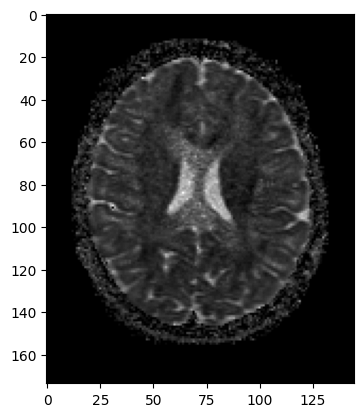

In [71]:
d_map[np.where(d_map<0)]=0
plt.figure()
plt.imshow(np.flipud(d_map.T),cmap='gray')
plt.show()

In [72]:
def ball_stick(x, bvals, qhat):
    # Behrens et al, 2003
    # Characterization and Propagation of Uncertainty in Diffusion-Weighted MR Imaging
    # https://doi.org/10.1002/mrm.10609
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f, theta, phi = x
    
    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
    return S


def BallStickSSD(x, voxel, bvals, qhat):
    S = ball_stick(x, bvals, qhat)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

In [73]:
startx = np.array([3500, -5e-6, 120, 0, 0])
#startx = np.array([4200, 4e-4, 0.25, 0, 0])
avox = dwis[:,91,64,71]
results = minimize(
    fun=BallStickSSD,
    x0=startx,
    args=(avox, bvals, qhat)
)

In [74]:
results

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 28744682.87038377
        x: [ 3.520e+03 -5.122e-06  1.178e+02  8.864e-01  1.559e+00]
      nit: 10
      jac: [-1.460e+02  1.404e+10  9.220e+02 -1.327e+05  1.162e+05]
 hess_inv: [[ 1.304e-02 -2.397e-12 ... -1.707e-06  5.561e-07]
            [-2.397e-12  1.936e-18 ... -1.235e-14  2.702e-14]
            ...
            [-1.707e-06 -1.235e-14 ...  1.025e-08  5.846e-09]
            [ 5.561e-07  2.702e-14 ...  5.846e-09  2.173e-08]]
     nfev: 342
     njev: 55

In [75]:
avox = dwis[:,65,23,71]
avox


array([354.9836731 , 385.05163574, 361.7046814 , 233.44163513,
       162.65438843, 259.01052856, 443.01052856, 278.03338623,
       172.39466858, 231.08079529, 321.24441528, 279.96878052,
       267.19335938, 201.95091248, 451.75878906, 269.93984985,
       254.09107971, 205.24269104, 345.06268311, 142.29452515,
       222.07157898, 267.09423828, 274.58956909, 335.60025024,
       421.59036255, 306.08016968, 229.17584229, 270.7722168 ,
       152.80497742, 168.22463989, 460.29949951, 185.5189209 ,
       399.59939575, 160.40510559, 286.22201538, 281.13131714,
       182.38713074, 240.69180298, 309.3223877 , 314.97640991,
       256.55014038, 219.57849121, 394.90518188, 229.47906494,
       284.28170776, 155.94963074, 302.24649048, 282.46990967,
       412.05792236, 264.60968018, 180.62335205, 400.47918701,
       207.34906006, 256.60681152, 324.09161377, 228.36433411,
       308.06137085, 239.23373413, 206.0504303 , 341.69110107,
       397.02185059, 194.55827332, 198.23486328, 220.72

Q1.1.1. Implement linear diffusion tensor estimation (see lecture notes, DTI 
tutorial video, and below) and use it to map the mean diffusivity, fractional 
anisotropy, and colour-coded principal direction over one slice of the image. 

Must solve $A=Yx$

Where $\bold{A}$ is vector of log measurements <br>
Where $Y$ is design matrix <br>
$x$ is list of unknown parameters 

In [76]:

# Eigenvalues from diffusion tensor decomposition (assume shape is (3, Dx, Dy))
lambda1 = dt_map[0, :, :]
lambda2 = dt_map[1, :, :]
lambda3 = dt_map[2, :, :]

# Mean diffusivity
lambda_mean = (lambda1 + lambda2 + lambda3) / 3

# Compute FA
FA_map = np.sqrt(1.5 * ((lambda1 - lambda_mean)**2 +
                         (lambda2 - lambda_mean)**2 +
                         (lambda3 - lambda_mean)**2) /
                         (lambda1**2 + lambda2**2 + lambda3**2))

C:\Users\Gugu\AppData\Local\Temp\ipykernel_11188\2962221754.py:10: RuntimeWarning: invalid value encountered in divide
  FA_map = np.sqrt(1.5 * ((lambda1 - lambda_mean)**2 +


In [77]:
# Assuming dt_map has shape (7, Dx, Dy)
Dx, Dy = dt_map.shape[1], dt_map.shape[2]

# Initialize a 3x3 tensor field
D = np.zeros((3, 3, Dx, Dy))

# Assign the symmetric components of the diffusion tensor
D[0, 0, :, :] = dt_map[1, :, :]  # D_xx
D[0, 1, :, :] = dt_map[2, :, :]  # D_xy
D[0, 2, :, :] = dt_map[3, :, :]  # D_xz

D[1, 0, :, :] = dt_map[2, :, :]  # D_yx (same as D_xy)
D[1, 1, :, :] = dt_map[4, :, :]  # D_yy
D[1, 2, :, :] = dt_map[5, :, :]  # D_yz

D[2, 0, :, :] = dt_map[3, :, :]  # D_zx (same as D_xz)
D[2, 1, :, :] = dt_map[5, :, :]  # D_zy (same as D_yz)
D[2, 2, :, :] = dt_map[6, :, :]  # D_zz

In [80]:
print("D_xx range:", np.min(D_xx), np.max(D_xx))
print("D_yy range:", np.min(D_yy), np.max(D_yy))
print("D_zz range:", np.min(D_zz), np.max(D_zz))


D_xx range: -0.0011912263569804045 0.003421606681404268
D_yy range: -0.0010533042404465391 0.0034375035623550286
D_zz range: -0.001079548256890868 0.0034229277024718603


In [81]:
print("trace_D shape:", trace_D.shape)
print("trace_D range:", np.min(trace_D), np.max(trace_D))

trace_D shape: (174, 145)
trace_D range: -0.0033240788543178116 0.010074579463496852


In [79]:
print("dt_map shape:", dt_map.shape)
print("NaNs in dt_map:", np.isnan(dt_map).sum())

dt_map shape: (7, 145, 174)
NaNs in dt_map: 0


In [ ]:
from numpy.linalg import eig

# Compute eigenvectors and eigenvalues of D (assume D is (3,3,Dx,Dy))
eigenvalues, eigenvectors = np.linalg.eigh(D)

# Extract primary eigenvector (largest eigenvalue)
v1 = eigenvectors[:, :, :, -1]  # Shape: (3, Dx, Dy)

LinAlgError: Last 2 dimensions of the array must be square

In [ ]:
RGB_map = np.zeros((Dx, Dy, 3))  # Initialize color map

RGB_map[..., 0] = np.abs(v1[0, :, :]) * FA_map  # Red (x-direction)
RGB_map[..., 1] = np.abs(v1[1, :, :]) * FA_map  # Green (y-direction)
RGB_map[..., 2] = np.abs(v1[2, :, :]) * FA_map  # Blue (z-direction)


In [ ]:
RGB_map = np.zeros((Dx, Dy, 3))  # Initialize color map

RGB_map[..., 0] = np.abs(v1[0, :, :]) * FA_map  # Red (x-direction)
RGB_map[..., 1] = np.abs(v1[1, :, :]) * FA_map  # Green (y-direction)
RGB_map[..., 2] = np.abs(v1[2, :, :]) * FA_map  # Blue (z-direction)


In [ ]:
import matplotlib.pyplot as plt

RGB_map = RGB_map / np.max(RGB_map)  # Normalize to [0,1]

plt.figure(figsize=(6, 6))
plt.imshow(RGB_map)
plt.axis("off")
plt.title("Directionally Encoded Color FA Map")
plt.show()


In [ ]:
D = np.zeros((3, 3, Dx, Dy))
D[0, 0, :, :] = dt_map[1, :, :]  # D_xx
D[0, 1, :, :] = dt_map[2, :, :]  # D_xy
D[0, 2, :, :] = dt_map[3, :, :]  # D_xz
D[1, 0, :, :] = dt_map[2, :, :]  # D_yx (same as D_xy)
D[1, 1, :, :] = dt_map[4, :, :]  # D_yy
D[1, 2, :, :] = dt_map[5, :, :]  # D_yz
D[2, 0, :, :] = dt_map[3, :, :]  # D_zx (same as D_xz)
D[2, 1, :, :] = dt_map[5, :, :]  # D_zy (same as D_yz)
D[2, 2, :, :] = dt_map[6, :, :]  # D_zz
